In [2]:
# External libraries import
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
# Local libraries import
from python.AReS import Simulator, Model, Interaction, DoHMeasure, DisturbanceType

In [4]:
stimuli = {
    1 * 60: (DisturbanceType.INTUBATION, 2 * 60, [10, 10, 20]), 
    5 * 60: (DisturbanceType.INCISION, 2 * 60, [10, 10, 20]),  
    10 * 60: (DisturbanceType.SKIN_MANIPULATION, 10 * 60, [5, 5,10]),
    21 * 60: (DisturbanceType.SUTURE, 5 * 60, [2, 2, 4]) 
}

In [5]:
simulator = Simulator.create()
interaction = Interaction.SURFACE
doh_measure = DoHMeasure.BOTH
t_sim = 30 * 60
t_s = 5
pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}

In [6]:
u_prop = [0.2] * t_sim
u_remi = [0.2] * t_sim
u_nore = [0.01] * t_sim
u_rocu = [0.1] * t_sim

In [7]:
ground_truth = {'_BIS_all':10, '_WAV_all':10, '_MAP_all':20, '_HR_all':10}

names = {'_BIS_all': 'BIS', '_WAV_all': 'WAV', '_MAP_all': 'MAP', '_HR_all': 'HR'}

In [8]:
flag = True

for k in [2,2]:
    simulator.init_simulation_from_file(id_patient=k, t_sim=t_sim, t_s=t_s, pk_models=pk_models,
                                        pd_models=pd_models, interaction=interaction, doh_measure=doh_measure,worst_case=True,stimuli=stimuli if flag else None)
    
    simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu)
    flag = False
    simulator.save_simulation()

results = simulator.get_patient_results()

In [9]:
for start, value in stimuli.items():
    type, duration, params = value
    print(f"Disturbance: {type.name}")
    for key in ground_truth.keys():
        diff = results[key][0][start+duration] - results[key][1][start+duration]
        if type in [DisturbanceType.SKIN_MANIPULATION, DisturbanceType.SUTURE]:
            diff -= ground_truth[key]
        print(f"    Parameter: {names[key]}: {diff}")

Disturbance: INTUBATION
    Parameter: BIS: 9.902462582729086
    Parameter: WAV: 10.0
    Parameter: MAP: 19.999999999999986
    Parameter: HR: 10.000000000000007
Disturbance: INCISION
    Parameter: BIS: 9.864134586691058
    Parameter: WAV: 10.00706586125537
    Parameter: MAP: 20.014131722510726
    Parameter: HR: 10.007065861255377
Disturbance: SKIN_MANIPULATION
    Parameter: BIS: 1.2763427501388591
    Parameter: WAV: -0.00047493941747944746
    Parameter: MAP: -0.0009498788349660003
    Parameter: HR: -0.0004749394174865529
Disturbance: SUTURE
    Parameter: BIS: 1.990148934556771
    Parameter: WAV: 1.999494745471992
    Parameter: MAP: 3.998989490943984
    Parameter: HR: 1.999494745471992


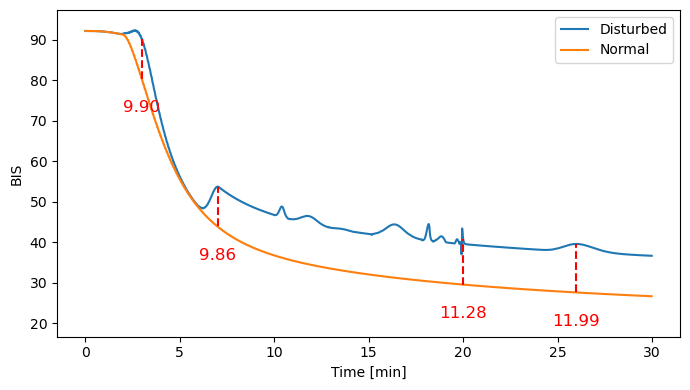

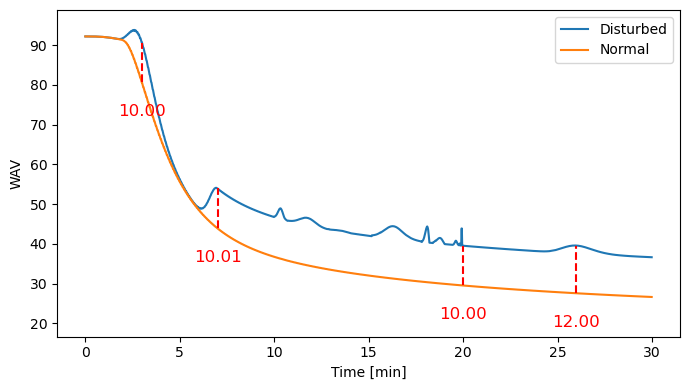

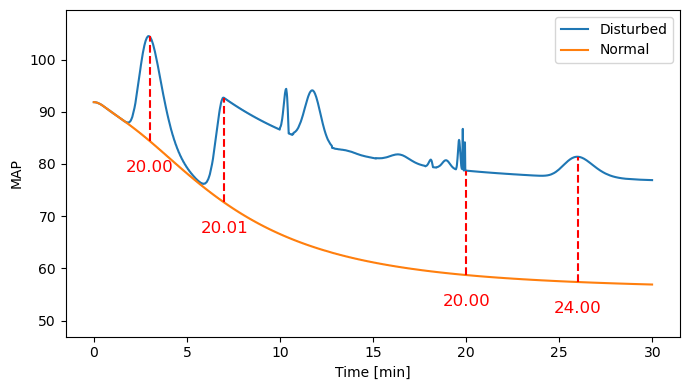

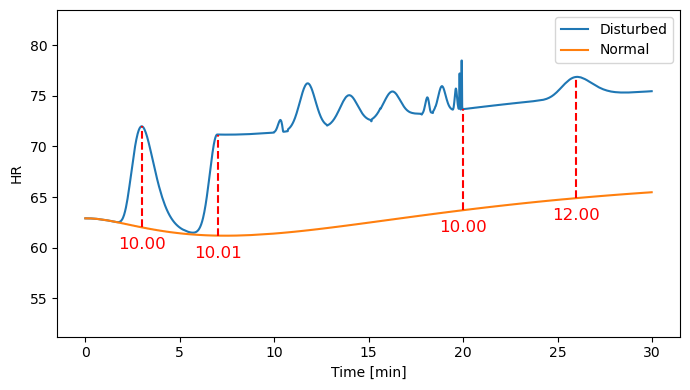

In [10]:
num_samples = len(results['_BIS_all'][0])
t = np.arange(num_samples) / 60

for key in ground_truth.keys():
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(t,results[key][0], label='Disturbed')
    ax.plot(t,results[key][1], label='Normal')
    ax.set_ylim(min(results[key][1]) - 10, max(results[key][0]) + 5)

    for start, value in stimuli.items():
        type, duration, params = value
        x = math.floor((start + duration) / 60)
        y_max = results[key][0][start + duration]
        y_min = results[key][1][start + duration]
        ax.vlines(x=x, ymin=y_min, ymax=y_max, color='red', linestyle='--')
        delta_y = (max(results[key][0]) - min(results[key][1])) / 8
        ax.text(x, y_min - delta_y, f"{(y_max-y_min):.2f}", color='red', fontsize=12, ha='center')

    ax.set_xlabel('Time [min]')
    ax.set_ylabel(names[key])
    ax.legend()
    plt.tight_layout()
    plt.show()

In [11]:
simulator.reset()

patient_id = 1
for idx, k in enumerate([patient_id, patient_id, patient_id,patient_id]):
    is_disturbed = (idx % 2 == 0)
    current_stimuli = stimuli if is_disturbed else None

    simulator.init_simulation_from_file(
        id_patient=k,
        t_sim=t_sim,
        t_s=t_s,
        pk_models=pk_models,
        pd_models=pd_models,
        interaction=interaction,
        doh_measure=doh_measure,
        seed_disturbance=42,
        stimuli=current_stimuli
    )

    simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu)
    simulator.save_simulation()

# Fetch all results after simulations
results = simulator.get_patient_results()

In [12]:

# Compare disturbed (i) vs undisturbed (i+1) for each pair
for i in range(0, 4, 2):
    print(f"\nPatient {patient_id}")
    for start, value in stimuli.items():
        disturbance_type, duration, params = value
        print(f" Disturbance: {disturbance_type.name}")
        for key in ground_truth:
            disturbed = results[key][i][start + duration]
            normal = results[key][i + 1][start + duration]
            diff = disturbed - normal
            print(f"    {names[key]}: {diff:.2f}")


Patient 1
 Disturbance: INTUBATION
    BIS: 9.85
    WAV: 9.98
    MAP: 19.97
    HR: 9.98
 Disturbance: INCISION
    BIS: 1.97
    WAV: 2.00
    MAP: 4.00
    HR: 2.00
 Disturbance: SKIN_MANIPULATION
    BIS: 3.41
    WAV: 2.00
    MAP: 4.00
    HR: 2.00
 Disturbance: SUTURE
    BIS: 2.40
    WAV: 2.40
    MAP: 4.80
    HR: 2.40

Patient 1
 Disturbance: INTUBATION
    BIS: 9.85
    WAV: 9.98
    MAP: 19.97
    HR: 9.98
 Disturbance: INCISION
    BIS: 1.97
    WAV: 2.00
    MAP: 4.00
    HR: 2.00
 Disturbance: SKIN_MANIPULATION
    BIS: 3.41
    WAV: 2.00
    MAP: 4.00
    HR: 2.00
 Disturbance: SUTURE
    BIS: 2.40
    WAV: 2.40
    MAP: 4.80
    HR: 2.40


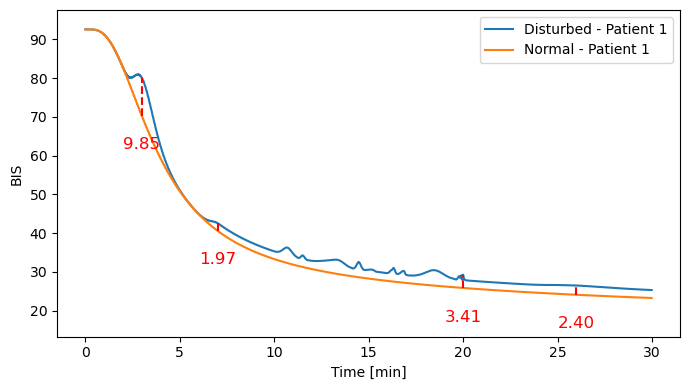

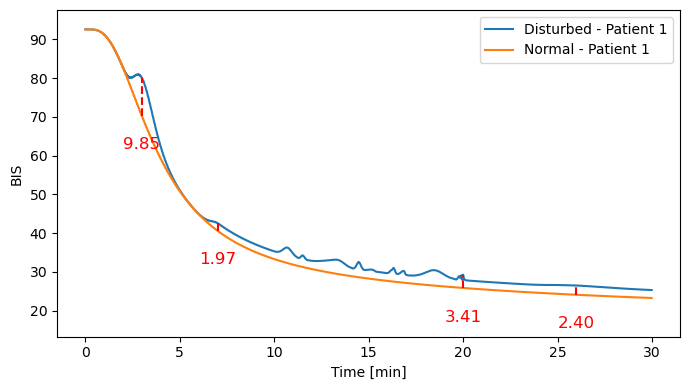

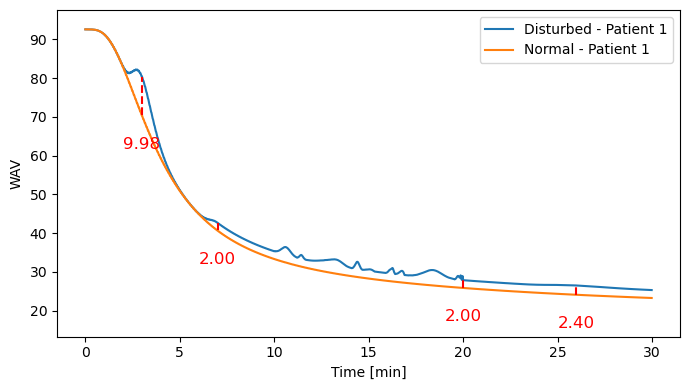

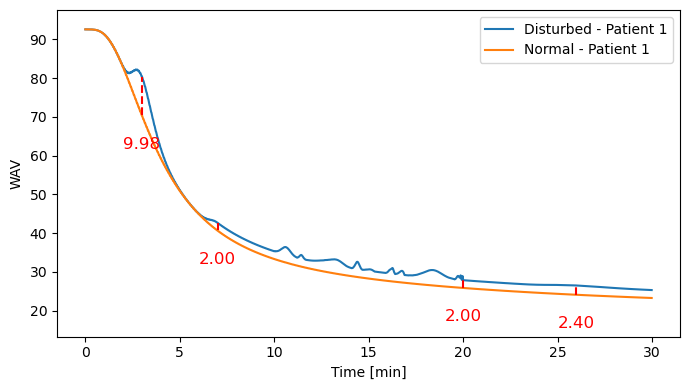

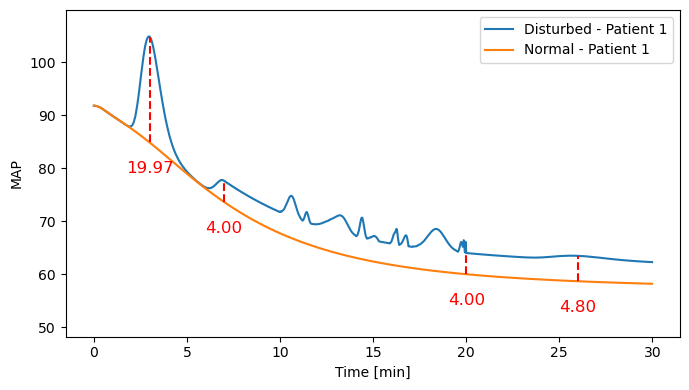

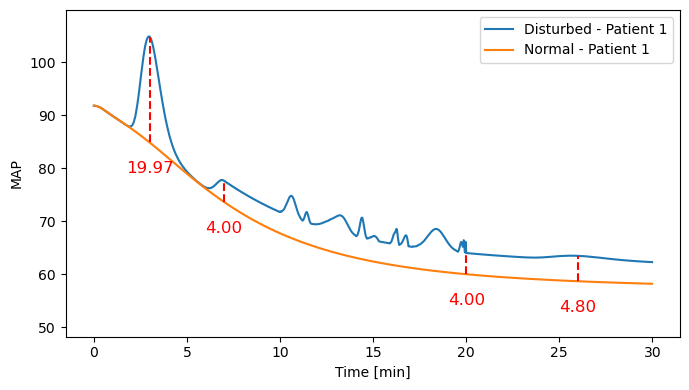

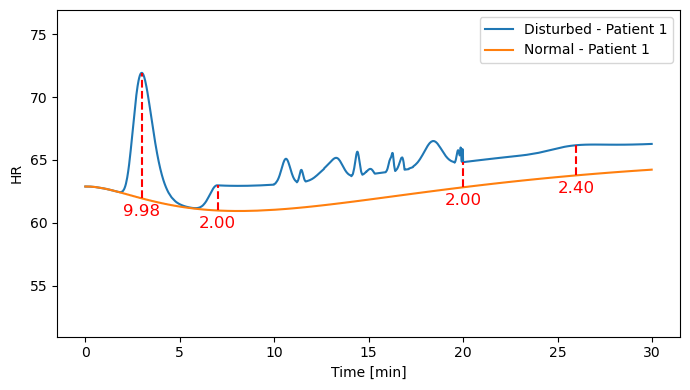

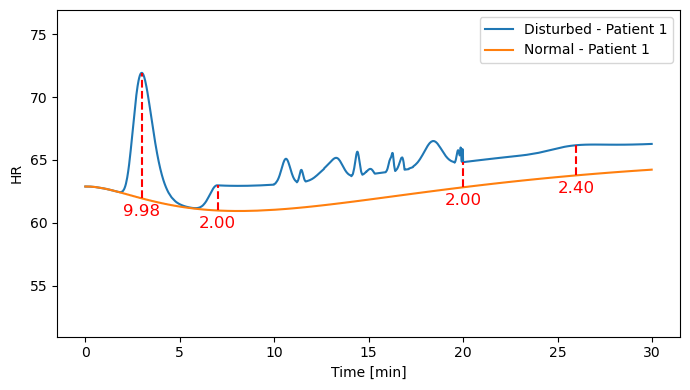

In [13]:
for key in ground_truth.keys():
    for i in range(0, 4, 2):
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(t,results[key][i], label='Disturbed - Patient ' + str(patient_id))
        ax.plot(t,results[key][i+1], label='Normal - Patient ' + str(patient_id))
        ax.set_ylim(min(results[key][i+1]) - 10, max(results[key][i]) + 5)
    
        for start, value in stimuli.items():
            type, duration, params = value
            x = math.floor((start + duration) / 60)
            y_max = results[key][i][start + duration]
            y_min = results[key][i+1][start + duration]
            ax.vlines(x=x, ymin=y_min, ymax=y_max, color='red', linestyle='--')
            delta_y = (max(results[key][i]) - min(results[key][i+1])) / 8
            ax.text(x, y_min - delta_y, f"{(y_max-y_min):.2f}", color='red', fontsize=12, ha='center')
    
        ax.set_xlabel('Time [min]')
        ax.set_ylabel(names[key])
        ax.legend()
        plt.tight_layout()
        plt.show()